In [2]:
## Importing Libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam

In [3]:
# Training Image Preprocessing
training_set = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 7392 files belonging to 5 classes.


In [4]:
# Validation Image Preprocessing
validation_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2160 files belonging to 5 classes.


In [5]:
num_classes = len(training_set.class_names)

In [6]:
# Define input shape
input_shape = (128, 128, 3)

# Load pre-trained EfficientNetB3 model without top (include_top=False)
base_model = EfficientNetB3(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the pre-trained weights
base_model.trainable = False

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 436s 10us/step


In [7]:
# Add classification head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation='softmax')(x)  # num_classes is the number of classes in your dataset

In [8]:
# Create the model
model = models.Model(inputs=base_model.input, outputs=output)

In [9]:
# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
# Display model summary
# model.summary()

In [10]:
# Train the model
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=4  # You can adjust the number of epochs as needed
)

Epoch 1/4
231/231 ━━━━━━━━━━━━━━━━━━━━ 232s 938ms/step - accuracy: 0.5965 - loss: 0.8416 - val_accuracy: 0.7667 - val_loss: 0.5655
Epoch 2/4
231/231 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.7168 - loss: 0.6099 - val_accuracy: 0.8019 - val_loss: 0.4873
Epoch 3/4
231/231 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.7629 - loss: 0.5263 - val_accuracy: 0.8069 - val_loss: 0.4417
Epoch 4/4
231/231 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7799 - loss: 0.4889 - val_accuracy: 0.8375 - val_loss: 0.3920


In [11]:
train_loss,train_acc = model.evaluate(training_set)

231/231 ━━━━━━━━━━━━━━━━━━━━ 174s 751ms/step - accuracy: 0.8295 - loss: 0.3935


In [12]:
val_loss,val_acc = model.evaluate(validation_set)

68/68 ━━━━━━━━━━━━━━━━━━━━ 49s 723ms/step - accuracy: 0.8333 - loss: 0.3965


In [13]:
class_name = validation_set.class_names

In [14]:
test_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2160 files belonging to 5 classes.


In [15]:
y_pred = model.predict(test_set)

2160/2160 ━━━━━━━━━━━━━━━━━━━━ 80s 36ms/step


In [16]:
predicted_categories = tf.argmax(y_pred,axis=1)

In [17]:
true_categories = tf.concat([y for x,y in test_set],axis=0)

2024-06-07 00:17:08.305442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
Y_true = tf.argmax(true_categories,axis=1)

In [19]:
from sklearn.metrics import classification_report,confusion_matrix

In [20]:
print(classification_report(Y_true,predicted_categories,target_names=class_name))


                            precision    recall  f1-score   support

       Cauliflower_Healthy       0.96      0.96      0.96       420
  Cauliflower_Healthy_Leaf       0.79      0.97      0.87       624
Cauliflower_Leaf_Black_Rot       0.84      0.47      0.60       372
 Cauliflower_Leaf_Red_Spot       0.70      0.73      0.71       372
      Cauliflower_Spot_Rot       0.95      0.95      0.95       372

                  accuracy                           0.84      2160
                 macro avg       0.85      0.82      0.82      2160
              weighted avg       0.84      0.84      0.83      2160



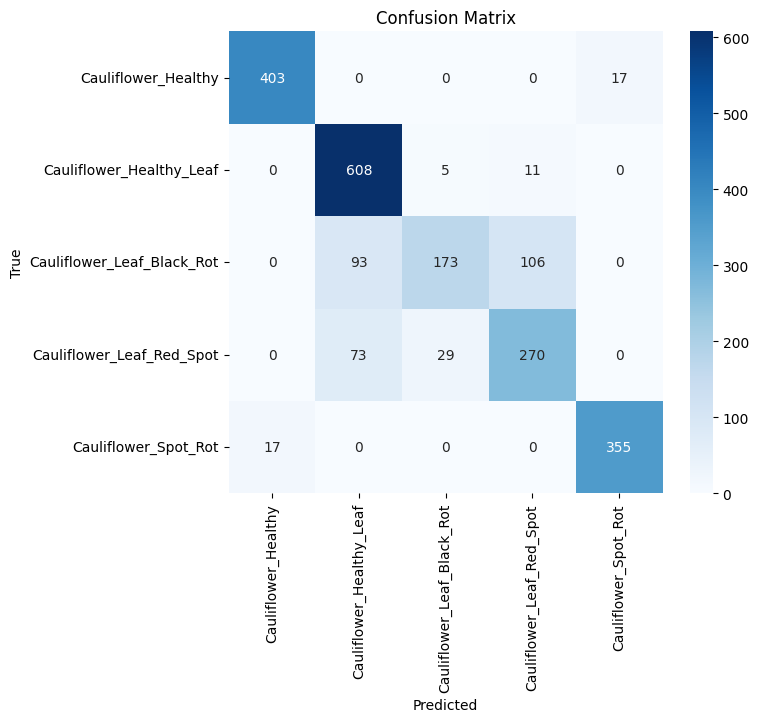

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(Y_true, predicted_categories)

# Plot confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

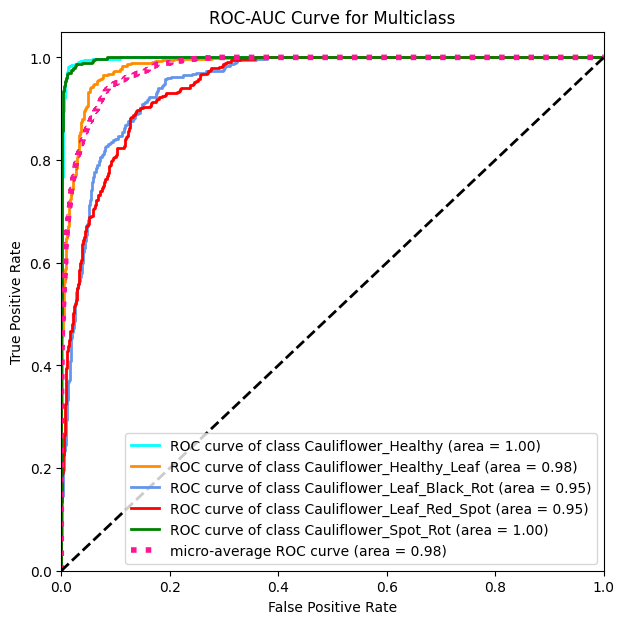

In [22]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the true categories
Y_true_binarized = label_binarize(Y_true, classes=[0, 1, 2, 3, 4])
n_classes = Y_true_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(7, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()

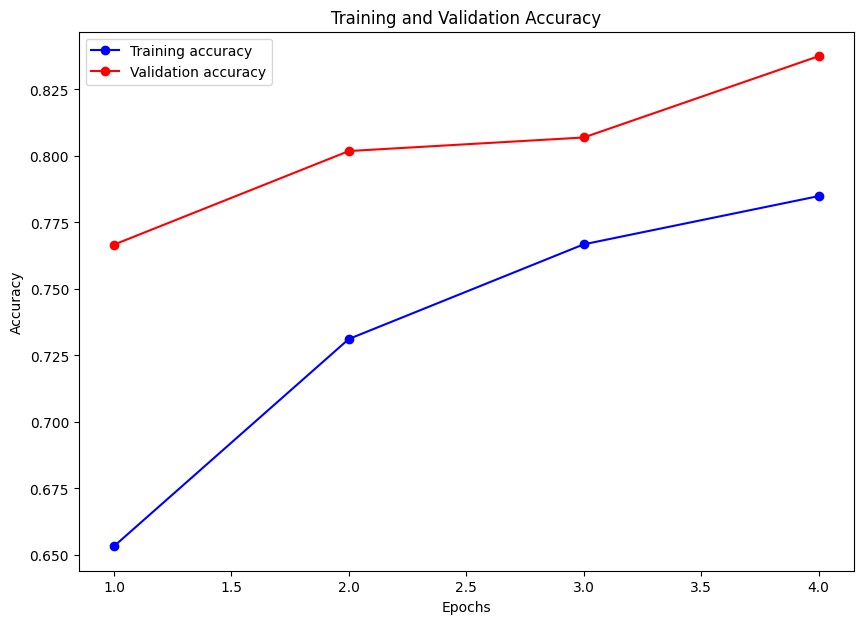

In [24]:
# Extract training and validation accuracy from the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 7))
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

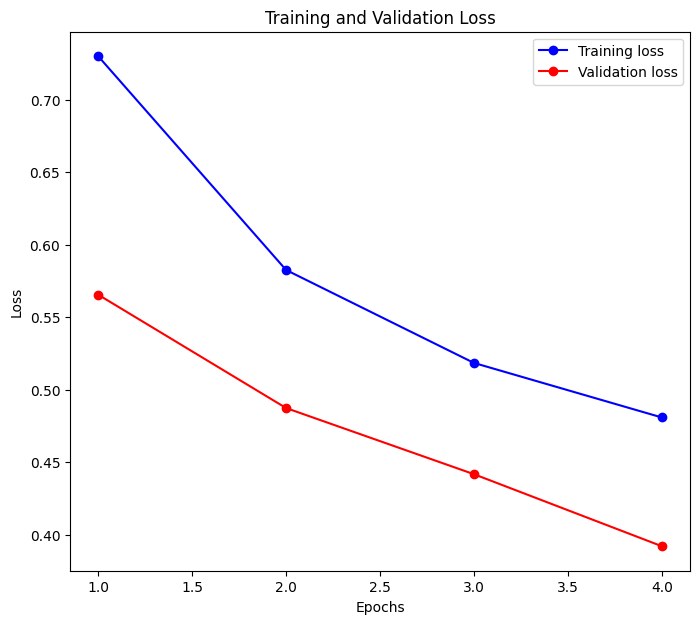

In [26]:
# Extract training and validation loss from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 7))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

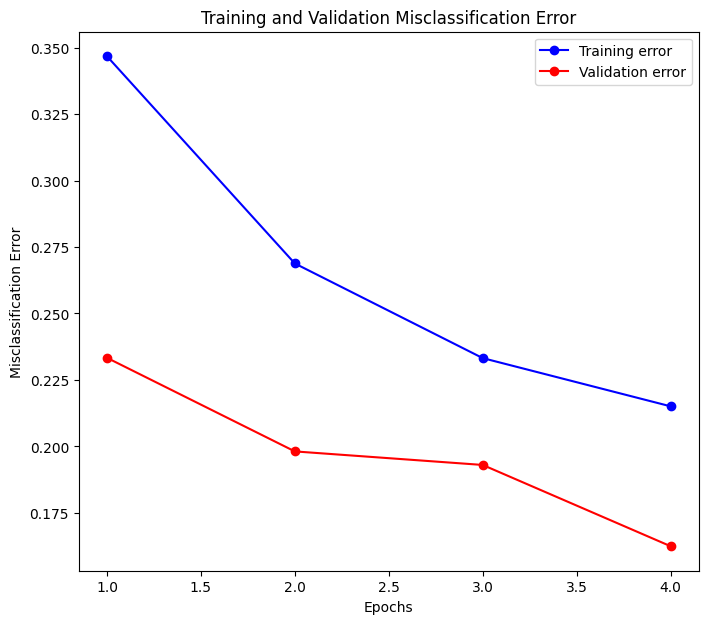

In [27]:
# Extract training and validation accuracy from the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Compute misclassification error
train_error = [1 - acc for acc in accuracy]
val_error = [1 - acc for acc in val_accuracy]

# Plot misclassification error
plt.figure(figsize=(8, 7))
plt.plot(epochs, train_error, 'bo-', label='Training error')
plt.plot(epochs, val_error, 'ro-', label='Validation error')
plt.title('Training and Validation Misclassification Error')
plt.xlabel('Epochs')
plt.ylabel('Misclassification Error')
plt.legend()
plt.show()

In [25]:
# Plot training history
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()